<a href="https://colab.research.google.com/github/parjhanya/Image_Classification/blob/master/CIFAR_10_KERAS_Transfer_Learning_Cat_Misclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import os

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
import itertools
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from keras import Sequential
from keras.applications import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.utils import to_categorical

In [ ]:
#Import dataset
from keras.datasets import cifar10

In [ ]:
#Divide the data in Train, Validation and Test Datasets
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [ ]:
#Print the dimensions of the datasets
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [ ]:
#One hot encode the labels.Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [ ]:
# Print the dimensions one more time
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


In [ ]:
#Data Augmentation Function: Let's define an instance of the ImageDataGenerator class and set the parameters.We have to instantiate for the Train,Validation and Test datasets
train_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1 )

val_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1)

test_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip= True,
                                    zoom_range=.1) 


In [ ]:
#Fit the augmentation method to the data

train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [ ]:
lrr= ReduceLROnPlateau(
                       monitor='val_acc', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5) #The minimum learning rate 

In [ ]:
#Build the model

#The first base model used is VGG19. The pretrained weights from the imagenet challenge are used
base_model_1 = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])


80142336/80134624 [==============================] - 3s 0us/step


In [ ]:
#Lets add the final layers to these base models where the actual classification is done in the dense layers

model_1= Sequential()
model_1.add(base_model_1) #Adds the base model (in this case vgg19 to model_1)
model_1.add(Flatten()) #Since the output before the flatten layer is a matrix we have to use this function to get a vector of the form nX1 to feed it into the fully connected layers


In [ ]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Add the Dense layers along with activation and batch normalization
model_1.add(Dense(1024,activation=('relu'),input_dim=512))
model_1.add(Dense(512,activation=('relu'))) 
model_1.add(Dense(256,activation=('relu'))) 
#model_1.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_1.add(Dense(128,activation=('relu')))
#model_1.add(Dropout(.2))
model_1.add(Dense(10,activation=('softmax'))) #This is the classification layer


In [ ]:
#Check final model summary
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [ ]:
batch_size= 32
epochs=10

In [ ]:
learn_rate=.001

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
#adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


In [ ]:
#Compile the model

model_1.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_1.fit_generator(train_generator.flow(x_train,y_train,batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=x_train.shape[0]//batch_size,
                      validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),validation_steps=250,
                      callbacks=[lrr],verbose=1)

Epoch 1/10
1093/1093 [==============================] - 37s 34ms/step - loss: 1.4774 - accuracy: 0.4607 - val_loss: 0.8694 - val_accuracy: 0.6819
Epoch 2/10
   2/1093 [..............................] - ETA: 1:25 - loss: 1.0216 - accuracy: 0.6562

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1093/1093 [==============================] - 30s 28ms/step - loss: 0.8290 - accuracy: 0.7191 - val_loss: 0.6033 - val_accuracy: 0.7462
Epoch 3/10
1093/1093 [==============================] - 30s 28ms/step - loss: 0.6523 - accuracy: 0.7783 - val_loss: 0.6477 - val_accuracy: 0.7889
Epoch 4/10
1093/1093 [==============================] - 30s 28ms/step - loss: 0.5495 - accuracy: 0.8129 - val_loss: 0.6462 - val_accuracy: 0.8024
Epoch 5/10
1093/1093 [==============================] - 30s 27ms/step - loss: 0.4813 - accuracy: 0.8361 - val_loss: 0.4800 - val_accuracy: 0.8198
Epoch 6/10
1093/1093 [==============================] - 30s 28ms/step - loss: 0.4286 - accuracy: 0.8523 - val_loss: 0.5854 - val_accuracy: 0.8325
Epoch 7/10
1093/1093 [==============================] - 30s 28ms/step - loss: 0.3778 - accuracy: 0.8706 - val_loss: 0.7574 - val_accuracy: 0.8354
Epoch 8/10
1093/1093 [==============================] - 30s 28ms/step - loss: 0.3321 - accuracy: 0.8848 - val_loss: 0.2506 - val_accura

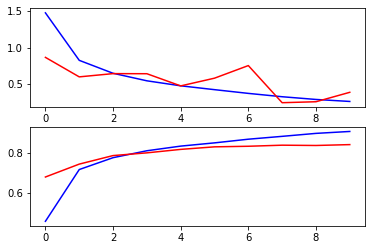

In [ ]:
#Plot the training and valiation loss

f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assign the first subplot to graph training loss and validation loss
ax[0].plot(model_1.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model_1.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model_1.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model_1.history.history['val_accuracy'],color='r',label='Validation Accuracy')

In [ ]:
scores = model_1.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model_1.predict(x_test)

10000/10000 [==============================] - 3s 274us/step
Test loss: 0.5175113663434983
Test accuracy: 0.84579998254776


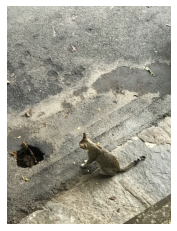

In [85]:
import cv2
from matplotlib import pyplot as plt
image_bgr = cv2.imread('/content/drive/My Drive/Image Classification/Saturday_Cat_2.JPG')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb), plt.axis("off")
plt.show()

In [86]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
img_path = '/content/drive/My Drive/Image Classification/Saturday_Cat_2.JPG'
label = ['airplane','automobile','bird','cat','deer','dog','frog','horse','snip','truck']
img = image.load_img('/content/drive/My Drive/Image Classification/Saturday_Cat_2.JPG')
newsize = (32, 32) 
img = img.resize(newsize)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
pred = model_1.predict(x)
pred = np.argmax(pred)
#print('Predicted Array:', pred)
print('Predicted Label:', label[pred])

Predicted Label: frog
